# RFM Clustering Performance
# 20233219 Taewoo Kim

## RFM K-means Clustering

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment',  None) #경고 끄기
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) #경고끄기

df = pd.read_csv("rfm_data.csv")
df.head()

,Customer ID,recency,frequency,monetary,RFM_Group,score,level
0,12346.0,325,12,77556.4600,133,7,Average
1,12347.0,2,8,4921.5300,333,9,Active
2,12348.0,75,5,2019.4000,223,7,Average
3,12349.0,18,4,4428.6904,323,8,Active
4,12350.0,310,1,334.4000,111,3,Inactive


In [2]:
#변수 스케일을 조정하여 정규화
k_rfm = df[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(k_rfm)
rfm_scaled

array([[ 0.59298505,  0.43874802,  5.16637863],
       [-0.94998781,  0.13139957,  0.13612762],
       [-0.60126639, -0.09911177, -0.06485615],
       ...,
       [ 2.19328197, -0.40646022, -0.17513604],
       [ 1.31431292, -0.32962311, -0.11492464],
       [-0.75890758,  0.05456245,  0.08498084]])

In [3]:
#apply k-means (k=8)
kmeans_scaled = KMeans(n_clusters=8, random_state=42)
kmeans_scaled.fit(rfm_scaled)

clusters_scaled = k_rfm.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(rfm_scaled)

clusters_scaled.groupby(['cluster_pred']).count()

,recency,frequency,monetary
cluster_pred,,,
0,6,6,6
1,1474,1474,1474
2,771,771,771
3,536,536,536
4,2,2,2
5,3025,3025,3025
6,10,10,10
7,54,54,54


In [4]:
# 개수가 적은 label 0,4,6,7을 병합
label_to_replace = [0,4,6,7]
clusters_scaled['cluster_pred'] = clusters_scaled['cluster_pred'].replace(label_to_replace, 'other')
clusters_scaled.groupby(['cluster_pred']).count()

,recency,frequency,monetary
cluster_pred,,,
1,1474,1474,1474
2,771,771,771
3,536,536,536
5,3025,3025,3025
other,72,72,72


In [5]:
# label값 재정의
clusters_scaled['cluster_pred'] = clusters_scaled['cluster_pred'].replace({5: 4, 'other': 5})
clusters_scaled.groupby(['cluster_pred']).count()

,recency,frequency,monetary
cluster_pred,,,
1,1474,1474,1474
2,771,771,771
3,536,536,536
4,3025,3025,3025
5,72,72,72


## Split data into train and test datasets

In [6]:
# split into train and test datasets
from sklearn import tree, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [7]:
new_df = clusters_scaled
print(type(new_df), new_df.shape)
new_df

<class 'pandas.core.frame.DataFrame'> (5878, 4)


,recency,frequency,monetary,cluster_pred
0,325,12,77556.46000,3
1,2,8,4921.53000,4
2,75,5,2019.40000,4
3,18,4,4428.69040,4
4,310,1,334.40000,1
...,...,...,...,...
5873,3,22,2664.90000,3
5874,431,1,461.68000,1
5875,660,1,426.99997,2
5876,476,2,1296.42990,2


In [8]:
X = new_df[['recency', 'frequency', 'monetary']]
y = new_df['cluster_pred']
class_name = list(set(y))

In [9]:
# default test data size: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=7)

## Decision Tree

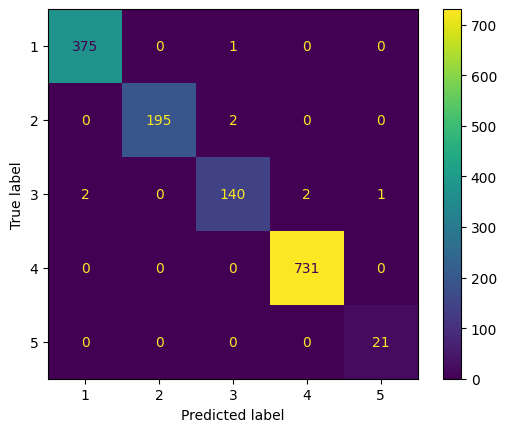

In [10]:
# Training with DecisionTree algorithm
rfmDT = tree.DecisionTreeClassifier().fit(X_train, y_train) # Decision Tree classifier
DT_y_pred = rfmDT.predict(X_test) # Classification, prediction

# visualize confusion matrix
confusion = metrics.confusion_matrix(y_test, DT_y_pred, labels=rfmDT.classes_)
metrics.ConfusionMatrixDisplay(confusion, display_labels=rfmDT.classes_).plot()
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

dt_acc = accuracy_score(y_test, DT_y_pred)
dt_p = precision_score(y_test, DT_y_pred, average='macro')
dt_r = recall_score(y_test, DT_y_pred, average='macro')
dt_f1 = f1_score(y_test, DT_y_pred, average='macro')

performance_df = pd.DataFrame({'Decision Tree': [dt_acc, dt_p, dt_r, dt_f1]})
performance_df.index = ['accuracy', 'precision', 'recall', 'F1']
performance_df

,Decision Tree
accuracy,0.994558
precision,0.985107
recall,0.990541
F1,0.987703


## Random Forest

In [12]:
rfmRF = RandomForestClassifier().fit(X_train, y_train)
RF_y_pred = rfmRF.predict(X_test)

In [13]:
rf_acc = accuracy_score(y_test, RF_y_pred)
rf_p = precision_score(y_test, RF_y_pred, average='macro')
rf_r = recall_score(y_test, RF_y_pred, average='macro')
rf_f1 = f1_score(y_test, RF_y_pred, average='macro')

performance_df['Random Forest'] = [rf_acc, rf_p, rf_r, rf_f1]
performance_df

,Decision Tree,Random Forest
accuracy,0.994558,0.993197
precision,0.985107,0.992897
recall,0.990541,0.990841
F1,0.987703,0.991860


## SVM

In [14]:
# Training with SVM algorithm
svmt = svm.SVC(kernel='linear', gamma = 'auto') # SVC for classification(RBF) and SVR for regression
svmt.fit(X_train, y_train)
svm_y_pred = svmt.predict(X_test)

In [15]:
svm_acc = accuracy_score(y_test, svm_y_pred)
svm_p = precision_score(y_test, svm_y_pred, average='macro')
svm_r = recall_score(y_test, svm_y_pred, average='macro')
svm_f1 = f1_score(y_test, svm_y_pred, average='macro')

performance_df['SVM'] = [svm_acc, svm_p, svm_r, svm_f1]
performance_df

,Decision Tree,Random Forest,SVM
accuracy,0.994558,0.993197,0.993197
precision,0.985107,0.992897,0.979415
recall,0.990541,0.990841,0.987299
F1,0.987703,0.991860,0.982824


## K-nearest Neighbors

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [17]:
knn_acc = accuracy_score(y_test, knn_y_pred)
knn_p = precision_score(y_test, knn_y_pred, average='macro')
knn_r = recall_score(y_test, knn_y_pred, average='macro')
knn_f1 = f1_score(y_test, knn_y_pred, average='macro')

performance_df['KNN'] = [knn_acc, knn_p, knn_r, knn_f1]
performance_df

,Decision Tree,Random Forest,SVM,KNN
accuracy,0.994558,0.993197,0.993197,0.924490
precision,0.985107,0.992897,0.979415,0.855033
recall,0.990541,0.990841,0.987299,0.804129
F1,0.987703,0.991860,0.982824,0.826955
